Resources:

https://github.com/FlynnOConnell/cpl_pipeline/tree/master/exclude  
https://github.com/cplab/ephys_analysis/blob/main/slice_analysis/lfp_analyses/filters.py  
https://github.com/cplab/ephys_analysis/blob/main/slice_analysis/filterCeedExperiment.py  
https://mark-kramer.github.io/Case-Studies-Python/03.html  

In [9]:
import h5py
import numpy as np

Extracting data

In [10]:
f=h5py.File("C:\\Users\\sinha\\Dropbox\\CPLab\\cpl data\\20230623_dk1_BW_context_day1.mat")
channels = list(sorted(f.keys()))
print(channels)

['V20230623_dk1_BW_context_day1_Ch1', 'V20230623_dk1_BW_context_day1_Ch2', 'V20230623_dk1_BW_context_day1_Ch29', 'V20230623_dk1_BW_context_day1_Ch3', 'V20230623_dk1_BW_context_day1_Ch31', 'V20230623_dk1_BW_context_day1_Ch4', 'V20230623_dk1_BW_context_day1_Ch5', 'V20230623_dk1_BW_context_day1_Ch6', 'V20230623_dk1_BW_context_day1_Ch8', 'file']


In [22]:

test=f[channels[4]]
print(test.keys())

print(np.array(test['start']).flatten())

<KeysViewHDF5 ['codes', 'comment', 'length', 'resolution', 'times', 'title']>


KeyError: "Unable to synchronously open object (object 'start' doesn't exist)"

1,2,3 : LFP AON
4,5,6: LFP vHC
8: reference 

In [3]:
channel_dict = {
    channel: (
        "LFP_AoN_1" if channel.endswith("_Ch1") else
        "LFP_AoN_2" if channel.endswith("_Ch2") else
        "LFP_AoN_3" if channel.endswith("_Ch3") else
        "LFP_VHC_1" if channel.endswith("_Ch4") else
        "LFP_VHC_2" if channel.endswith("_Ch5") else
        "LFP_VHC_3" if channel.endswith("_Ch6") else
        "reference" if channel.endswith("_Ch8") else
        "Unknown"
    )
    for channel in channels
}

print(channel_dict)

{'V20230623_dk1_BW_context_day1_Ch1': 'LFP_AoN_1', 'V20230623_dk1_BW_context_day1_Ch2': 'LFP_AoN_2', 'V20230623_dk1_BW_context_day1_Ch29': 'Unknown', 'V20230623_dk1_BW_context_day1_Ch3': 'LFP_AoN_3', 'V20230623_dk1_BW_context_day1_Ch31': 'Unknown', 'V20230623_dk1_BW_context_day1_Ch4': 'LFP_VHC_1', 'V20230623_dk1_BW_context_day1_Ch5': 'LFP_VHC_2', 'V20230623_dk1_BW_context_day1_Ch6': 'LFP_VHC_3', 'V20230623_dk1_BW_context_day1_Ch8': 'reference', 'file': 'Unknown'}


In [4]:
channel_data = f[channels[3]]
print(channel_data.keys())

<KeysViewHDF5 ['comment', 'interval', 'length', 'offset', 'scale', 'start', 'times', 'title', 'units', 'values']>


In [5]:
channel_data_values=list(channel_data['values'])
t=list(channel_data['times'])

In [6]:
import numpy as np

channel_data_values_flat = np.array(channel_data_values).flatten().tolist()
t_flat = np.array(t).flatten().tolist()

from pylab import *
from numpy.fft import rfft,fft
from scipy.signal import spectrogram
x = np.array(channel_data_values_flat)                               # Relabel the data variable
dt = t_flat[1] - t_flat[0]                      # Define the sampling interval
N = len(x)                        # Define the total number of data points
T = N * dt                            # Define the total duration of the data

xf = fft(x - x.mean())                # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * xf.conj())  # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]           # Ignore negative frequencies

df = 1 / T                      # Determine frequency resolution
fNQ = 1 / dt / 2                      # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)              # Construct frequency axis


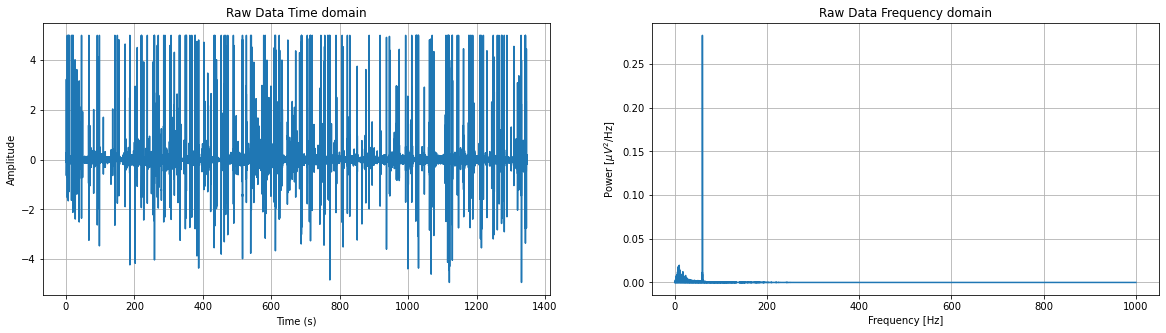

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot on the first subplot
ax[0].plot(t_flat, channel_data_values_flat)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Data Time domain')
ax[0].grid(True)

# Plot on the second subplot
ax[1].plot(faxis, Sxx.real)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Power [$\mu V^2$/Hz]')
ax[1].set_title('Raw Data Frequency domain')
ax[1].grid(True)

In [8]:
from scipy.signal import butter, lfilter, filtfilt, iirnotch

def iir_notch(data, fs, frequency, quality=15., axis=-1):

    norm_freq = frequency/(fs/2)
    b, a = iirnotch(norm_freq, quality)
    y = filtfilt(b, a, data, padlen=0, axis=axis)
    return y

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=4, axis=-1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, padlen=0, axis=axis)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5, axis=-1):
    nyq = fs * 0.5
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, padlen=0, axis=axis)
    return y

def frequency_domain(data, time):
    x= np.array(data)
    dt = time[1] - time[0]
    N = len(x)
    T = N * dt
    xf = fft(x - x.mean())
    Sxx = 2 * dt ** 2 / T * (xf * xf.conj())
    Sxx = Sxx[:int(len(x) / 2)]
    df = 1 / T
    fNQ = 1 / dt / 2
    faxis = np.arange(0,fNQ,df)[:len(Sxx)]
    return faxis, Sxx.real



Applying lowpass filter

In [9]:
import scipy.signal
low_pass = butter_lowpass_filter(channel_data_values_flat, 500, 2000)


Applying Resampling

In [10]:
# Calculate the new number of samples
original_sample_rate = 2000  # Original sample rate in Hz
new_sample_rate = 1000  # Desired sample rate in Hz
num_samples = len(low_pass)
duration = num_samples / original_sample_rate  # Duration in seconds
new_num_samples = int(duration * new_sample_rate)

filtered_data_resample=scipy.signal.resample(low_pass, new_num_samples)
time_resample = np.linspace(t_flat[0], t_flat[-1], new_num_samples)


Applying Highpass filter and Notch

In [11]:
filtered_data_resample_highpass = butter_highpass_filter(filtered_data_resample, 1, 1000)
filtered_data_resample_highpass_notch = iir_notch(filtered_data_resample_highpass, 1000, 60, quality=15.)

In [12]:
all_data = [channel_data_values_flat, low_pass, filtered_data_resample, filtered_data_resample_highpass, filtered_data_resample_highpass_notch]

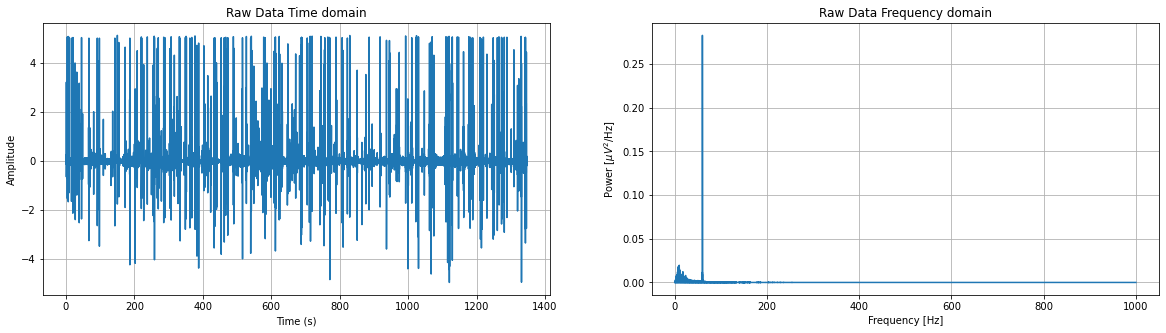

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

faxis,Sxx = frequency_domain(low_pass, t_flat)

# Plot on the first subplot
ax[0].plot(t_flat, low_pass)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Data after Low pass Time domain')
ax[0].grid(True)

# Plot on the second subplot
ax[1].plot(faxis, Sxx.real)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Power [$\mu V^2$/Hz]')
ax[1].set_title('Data after Low pass Frequency domain')
ax[1].grid(True)

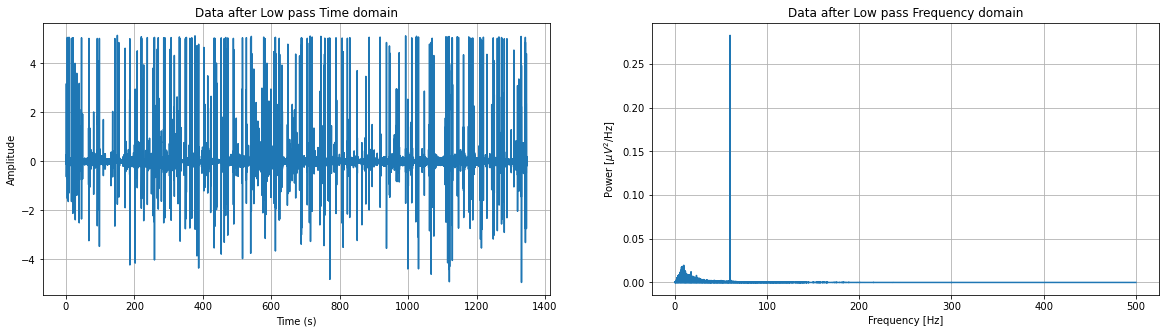

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

a=filtered_data_resample
b=time_resample
faxis,Sxx = frequency_domain(a, b)

# Plot on the first subplot
ax[0].plot(b, a)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Data after Resample Time domain')
ax[0].grid(True)

# Plot on the second subplot
ax[1].plot(faxis, Sxx.real)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Power [$\mu V^2$/Hz]')
ax[1].set_title('Data after Resample Frequency domain')
ax[1].grid(True)

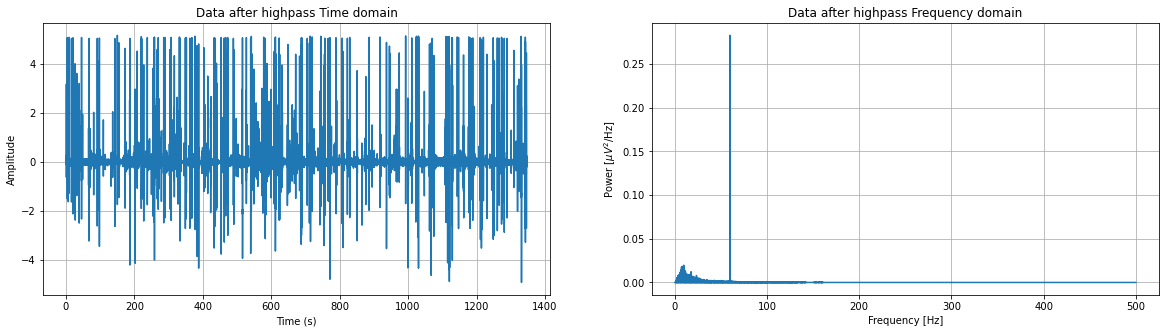

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

a=filtered_data_resample_highpass
b=time_resample
faxis,Sxx = frequency_domain(a, b)

# Plot on the first subplot
ax[0].plot(b, a)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Data after highpass Time domain')
ax[0].grid(True)

# Plot on the second subplot
ax[1].plot(faxis, Sxx.real)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Power [$\mu V^2$/Hz]')
ax[1].set_title('Data after highpass Frequency domain')
ax[1].grid(True)

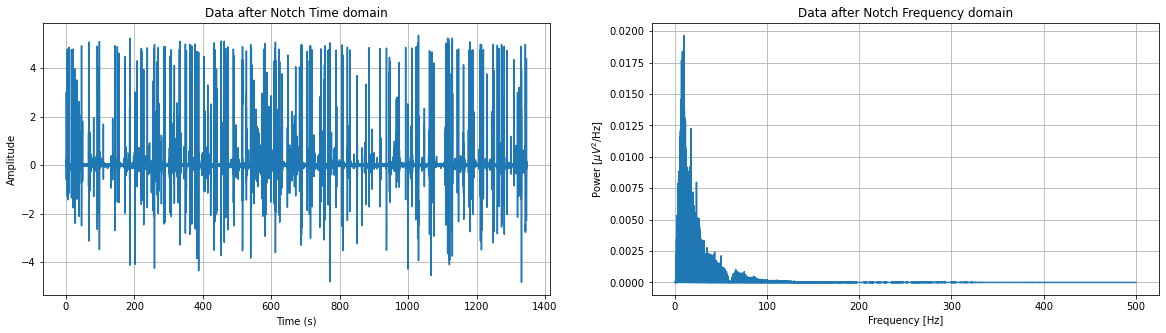

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

a=filtered_data_resample_highpass_notch
b=time_resample
faxis,Sxx = frequency_domain(a, b)

# Plot on the first subplot
ax[0].plot(b, a)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Data after Notch Time domain')
ax[0].grid(True)

# Plot on the second subplot
ax[1].plot(faxis, Sxx.real)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Power [$\mu V^2$/Hz]')
ax[1].set_title('Data after Notch Frequency domain')
ax[1].grid(True)

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(20, 5))

# Plot on the first subplot
ax[0,0].plot(t_flat,channel_data_values_flat)
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_title('Raw data Data')
ax[0,0].grid(True)

# Plot on the second subplot
ax[0,1].plot(t_flat, channel_data_values_flat)
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Amplitude')
ax[0,1].set_title('Channel Data')
ax[0,1].grid(True)

plt.show()

In [65]:
print(ax)

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


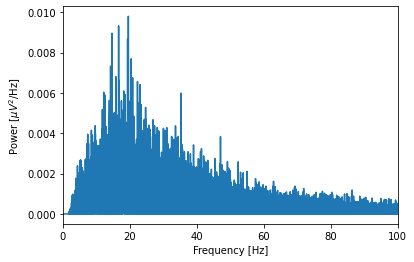

In [42]:
from pylab import *
from numpy.fft import rfft,fft
from scipy.signal import spectrogram
filtered_data_resample_highpass_notch=filtered_data_resample_highpass_notch[:-1]
x = np.array(filtered_data_resample_highpass_notch)                               # Relabel the data variable
dt = t_flat[1] - t_flat[0]                      # Define the sampling interval
N = len(x)                        # Define the total number of data points
T = N * dt                            # Define the total duration of the data

xf = fft(x - x.mean())                # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * xf.conj())  # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]           # Ignore negative frequencies

df = 1 / T                      # Determine frequency resolution
fNQ = 1 / dt / 2                      # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)[:len(Sxx)]              # Construct frequency axis

plot(faxis, Sxx.real)                 # Plot spectrum vs frequency
xlim([0, 100])                        # Select frequency range
xlabel('Frequency [Hz]')              # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
show()